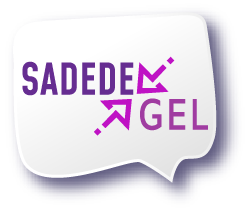

<div class="alert alert-block alert-warning">
<b>Kullanıcı Uyarısı:</b> <b>sadedegel</b> versiyonuzu <code>pip install sadedegel -U </code> kullanarak sık sık güncellemenizi tavsiye ediyoruz. Çünkü henüz kararlı major sürümde değiliz ve API lerde sürekli yazımsal ve anlamsal değişiklikler yapıyoruz. Anlayışınız ve desteğiniz için teşekkürler. 
</div>

In [ ]:
from sadedegel.about import __version__
__version__

## Offensive Turkish Tweets Classification
### with Sadedegel and Sklearn
#### by Askar Bozcan

#### Requirements: Altair for visualizations and Offensive Tweets dataset at https://coltekin.github.io/offensive-turkish

*A small disclaimer: The data at hand contains offensive content. Opinions presented in the tweets are those of their users and not Sadedegel team.*

---

In [ ]:
import torch
import numpy as np
import pandas as pd
from sadedegel.bblock import Doc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.sparse import vstack, csr_matrix # dealing with sparse matrices in  tfidf embeddings
from sklearn.preprocessing import normalize
import altair as alt
from tqdm import tqdm



### Data

In [ ]:
df = pd.read_csv("https://coltekin.github.io/offensive-turkish/troff-v1.0.tsv.gz", sep='\t')
df

The data we have at hand is a compilation of 35284 Turkish tweets, labelled by their type of offensive language. (Note that user handles are censored for privacy.)

**What are the labels?**

<ul>
    <li><b>non</b>offensive: Non-offensive tweets.</li>
    <li><b>prof</b>anity, or “untargeted offense”, is use of offensive language without a particular target. This is typically use of swear words, or other “inappropriate” language for stylistic reasons.</li>
    <li><b>grp</b> (offense towards a group) means the author intends to offend a group that forms a “unity” based on gender, ethnicity, political affiliation, religious belief or similar aspects of a person’s identity.</li>
    <li><b>ind</b> (offensive towards an individual) is used for offensive targeted to an individual or group of individuals that are not related in well-defined manner.</li>
    <li><b>oth</b> target of the offense is not one of the two cases above. This typically include organizations, events etc.</li>
</ul>

---

<br>

**What are the class counts?**

It is imperative to know how imbalanced the dataset is to make right decisions regarding splitting the data.

In [ ]:
class_counts = df["label"].value_counts()
class_counts = class_counts.reset_index()
class_counts = class_counts.rename(columns={"label":"counts", "index":"label"})
class_counts

In [ ]:
alt.Chart(class_counts, height=200).mark_bar(color="lightblue").encode(
    x=alt.X("counts:Q", title="Class count"),
    y=alt.Y("label:N", title="Off. tweet type")
).configure_axis(
    labelFontSize=12,
    titleFontSize=15
)



It seems that our dataset is highly imbalanced with most tweets being inoffensive, which would severely hamper our model's perforamance if we don't account for it.
<br>

---

### Preprocessing

Although most of the necessary preprocessing will be done by Sadedegel, we need to remove @User handles beforehand as the handles are useless, and may even hamper our model. A regex will be used to replace them with a blank string.

In [ ]:
df["text"] = df["text"].replace("@\S* ", "", regex=True)
df.head()

---
<br>
Next step is to convert text into TFIDF embeddings. Luckily getting those in Sadedegel is pretty easy and all you have to do is:
<ol>
    <li style="font-weight:bold"><span style="font-weight:normal">Turn the text into a Doc object.</span></li>
    <li style="font-weight:bold"><span style="font-weight:normal">Use .tfidf_embeddings property of Doc to get TFIDF embeddings in form of [NxV] where N is the number of sentences in the text and V is the size of vocabulary.</span></li>
    <li style="font-weight:bold"><span style="font-weight:normal">Average embeddings over the sentences in a tweet to get a single vector for a tweet which would be what is fed to the classifier as vector representation of the tweet.</span></li>
</ol>

Here is an example on 1 tweet:

In [ ]:
# Step 1
tweet_0 = Doc(df.iloc[103]["text"])
tweet_0

In [ ]:
# Step 2
tfidf_embedding_0 = tweet_0.tfidf_embeddings
tfidf_embedding_0.shape

In [ ]:
# Step 3
# average on sentence dimension
# (though in this example, there is only one sentence anyway )
tfidf_embedding_0_avg = tfidf_embedding_0.mean(axis=0)
tfidf_embedding_0_avg.shape

# And we're done!

Now, just like with above example, all that's left to do is to construct the training array, which will store embeddings for every tweet. Note that this might take a few minutes as it processess everything.

In [ ]:

X_str = df["text"]
X = []

for tweet in tqdm(X_str):
    d = Doc(tweet)
    X.append(csr_matrix(d.tfidf_embeddings.mean(axis=0)))


X = vstack(X)
print("Shape of embeddings matrix: ", X.shape)

As a last preprocessing step, let's normalize samples in our embeddings matrix.

In [ ]:
X = normalize(X)


Now that we have our training data, let's split the data into train and validation set, in a stratified fashion to prevent train and validation sets having different label distributions.

In [ ]:
y = df["label"]
X_train, X_val, y_train, y_val = train_test_split(X,y, stratify=df["label"], test_size=0.2)

Let's plot train and validation sets labels counts to ensure they have a similar label distribution.

In [ ]:
train_class_counts = y_train.value_counts().reset_index().rename(columns={"label":"counts", "index":"label"})
val_class_counts = y_val.value_counts().reset_index().rename(columns={"label":"counts", "index":"label"})

c1 = alt.Chart(train_class_counts, height=200, title="Train counts").mark_bar(color="lightblue").encode(
    
    x=alt.X("counts:Q", title="Class count"),
    y=alt.Y("label:N", title="Off. tweet type")
)

c2 = alt.Chart(val_class_counts, height=200, title="Validation counts").mark_bar(color="lightblue").encode(
    x=alt.X("counts:Q", title="Class count"),
    y=alt.Y("label:N", title="Off. tweet type")
)

c1 | c2


---

### Train and validate

Great! Both train and validation have similar distributions, however class imbalance is not gone. There are many ways to address this issue but for our particular purpose we'll use LogisticRegression's `class_weight` attribute which will allow us to automatically weigh each class.

In [ ]:
clf = LogisticRegression(random_state=0, max_iter=2000, class_weight="balanced").fit(X_train, y_train) # train

Now that our classifier is trained, let's predict our validation set.

In [ ]:
y_pred = clf.predict(X_val)
y_pred

For metric purposes, let's look at the confusion matrix and f1-score. Accuracy in this case is absolutely not the best metric due to highly unbalanced classes. If model just guessed "non", or non-offensive it would be quite accurate despite being useless as "non" class is a big majority class.

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

label_list = sorted(list(y_val.unique()))
cm = confusion_matrix(y_val, y_pred, labels=label_list)
x, y = np.meshgrid(range(cm.shape[0]), range(cm.shape[0]))

# Convert this grid to columnar data expected by Altair
source = pd.DataFrame({'x': x.ravel(),
                     'y': y.ravel(),
                     'z': cm.ravel()})

for i,label in enumerate(label_list):
    source.loc[:, "x"] = source.loc[:,"x"].replace(i, label)
    source.loc[:, "y"] = source.loc[:,"y"].replace(i, label)



base = alt.Chart(source, title="Confusion matrix").encode(
    x=alt.X("x:O", axis=alt.Axis(title="Predicted", titlePadding=30)),
    y=alt.Y("y:O", axis=alt.Axis(title="Ground truth", titlePadding=30)),
    color=alt.value('white')

)

hm = base.mark_rect(stroke='black')
    
text = base.mark_text(baseline='middle', size=15).encode(
    
    text='z:Q',
    color=alt.value('black')
    
)

(hm+text).properties(width=300, height=300)

However, what about accuracy and f1-score?

In [ ]:
print("Accuracy:", accuracy_score(y_val, y_pred, normalize=True))
print("F1:", f1_score(y_val, y_pred, average="macro"))

Not bad, but can be much better. However considering we used basic logistic regression, no hyperparameter optimization at all and basic features (tf-idf) this is a pretty decent result.

**How can we improve it?**
* Use BERT embeddings, as they are much richer in semantic information compared to tf-idf embeddings
* Use a more sophisticated classifier
* Feature selection, as tfidf vectors are huge (20k+ features, mostly 0s)
* Normalize text before getting the embeddings.

---

### Testing model on tweets found in the wild

In [ ]:
tweets = [
    """"Avrupa'da yollara ücret ödemeyen ancak Türkiye'de otobana 47,50 TL veren gurbetçinin isyanı; 'Ben Avrupa'yı karış karış geziyorum 1 kuruş ödemiyorum, ağlamam geldi , 1 haftada tüm dengem bozuldu. Avrupa Kapıları Açsa Herkes Kaçacak'" """,
    """Araştırmalar köpeklerin #Covid_19'u yüzde 100 doğru olarak tespit ettiğini gösterince Finlandiya Helsinki Havaalanı'nda özel eğitimli Kössi ve Miina adlı #köpek'ler pilot olarak çalışmaya başladı. Umarım hayvanlara zulmedenler bu güzellikten mahrum kalır""",
    """Sovyet Tankları Berline girene kadar Almanlar Rusya'yı işgal ettiklerini zannediyordu. Çünkü Alman gazeteleri öyle yazıyordu.""",
    """Yalancıyı Eşek siksinmi Avrupada Almanya hariç bütün ülkeler paralı""",
    """Yarrana sıçam""",
    """200 liraya rakı mı olur orospu çocukları jet yakıtı mı alıyoruz"""
]

tweets_embeds = []
for tweet in tweets:
    d = Doc(tweet)
    tweets_embeds.append(csr_matrix(d.tfidf_embeddings.mean(axis=0)))


tweets_embeds = vstack(tweets_embeds)
tweets_embeds = normalize(tweets_embeds)



preds = clf.predict(tweets_embeds)
preds

In [ ]:
cls_to_human = {
    "non": "Non-offensive",
    "grp": "Offense towards group",
    "prof": "Profanity",
    "ind": "Offense towards individual",
    "oth": "Other profanities"
}

Now, how about we test this on tweets found in the wild and see how our model will perform. 3 tweets non-offensive and 3 tweets of profanity class were picked. *Sadly, I had a hard time finding tweets of other profanity categories.*

Here are the tweets (predictions with code cells above tweets and their labels, as labelled by <a style="color:green; font-weight:bold">me</a>):

In [ ]:
cls_to_human[preds[0]]

<p style="background-color:#ebfcff; padding:10px; border:1px solid black; border-radius:1px">
<a style="color:green; font-weight:bold">Non-offensive</a><br>
"Avrupa'da yollara ücret ödemeyen ancak Türkiye'de otobana 47,50 TL veren gurbetçinin isyanı;
'Ben Avrupa'yı karış karış geziyorum 1 kuruş ödemiyorum, ağlamam geldi , 
1 haftada tüm dengem bozuldu. Avrupa Kapıları Açsa Herkes Kaçacak'"
</p>

In [ ]:
cls_to_human[preds[1]]

<p style="background-color:#ebfcff; padding:10px; border:1px solid black; border-radius:1px">
<a style="color:green; font-weight:bold">Non-offensive</a> <br>
    Araştırmalar köpeklerin #Covid_19'u yüzde 100 doğru olarak tespit ettiğini gösterince Finlandiya Helsinki Havaalanı'nda özel eğitimli Kössi ve Miina adlı #köpek'ler pilot olarak çalışmaya başladı. Umarım hayvanlara zulmedenler bu güzellikten mahrum kalır
</p>


In [ ]:
cls_to_human[preds[2]]

<p style="background-color:#ebfcff; padding:15px; border:1px solid black; border-radius:1px">
<a style="color:green; font-weight:bold">Non-offensive</a> <br>
Sovyet Tankları Berline girene kadar Almanlar Rusya'yı işgal ettiklerini zannediyordu. Çünkü Alman gazeteleri öyle yazıyordu.
</p>

In [ ]:
cls_to_human[preds[3]]

</p>
<p style="background-color:#ffb0b0; padding:10px; border:1px solid black; border-radius:1px">
<a style="color:green; font-weight:bold">Profanity</a><br>
Yalancıyı Eşek siksinmi
Avrupada Almanya hariç bütün ülkeler paralı
</p>


In [ ]:
cls_to_human[preds[4]]

<p style="background-color:#ffb0b0; padding:10px; border:1px solid black; border-radius:1px">
<a style="color:green; font-weight:bold">Profanity</a><br>
    Yarrana sıçam
</p>


In [ ]:
cls_to_human[preds[5]]

<p style="background-color:#ffb0b0; padding:10px; border:1px solid black; border-radius:1px">
<a style="color:green; font-weight:bold">Profanity</a><br>
200 liraya rakı mı olur orospu çocukları jet yakıtı mı alıyoruz
</p>

---

### References
Turkish offensive tweets dataset: https://coltekin.github.io/offensive-turkish

Sadedegel: https://sadedegel.ai
